In [1]:
# Visualising the data
# • Plot a probability density histogram for each type of stimulus. This height of each bar
# should be the proportion of responses divided by the width of the column.

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import glob
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

# Load the data
data = np.array([pd.read_csv("Data/Part_2/Homework3pt2DataCSV{}.txt".format(i), header = None, sep= "\s+") for i in range(1,6)], dtype=int)

In [2]:
# The first row of the array contains response counts for the auditory stimuli. The columns of
# the first row indicate the specific auditory stimulus ranging from very similar to a ’b’ in the
# first column to very similar to a ’d’ in the last column. Likewise, the second row contains
# response counts to the visual stimulus ranging from very similar to a ’b’ to very similar to a
# ’d’. Rows 3-7 contains response counts for the audiovisual stimuli. Rows indicate the visual
# component of the stimulus ranging from very similar to a ’b’ (row 3) to very similar to a ’d’
# (row 7). Columns indicate the auditory component of the stimulus ranging from very similar
# to a ’b’ (column 1) to very similar to a ’d’ (column 5).
# df_all

In [3]:
from scipy.stats import norm

means_ini = np.array([1,2,3,4,5])
# means_ini = [1,2,3,4,5]
sigma_a_ini = data[0].std(axis=0).mean()
sigma_v_ini = data[1].std(axis=0).mean()

In [4]:
def combined_distributions(means_atilde, means_vtilde, sigma_a_ini, sigma_v_ini):
    w_a = sigma_v_ini**2 / (sigma_v_ini**2 + sigma_a_ini**2)
    #w_v = (sigma_a_ini)**2 / ((sigma_a_ini)**2 + (sigma_v_ini)**2)
    
    # 5 by 5 matrix of 0 
    means_av_matrix= np.zeros((5,5))
    for i in range(5):
        for j in range(5):
            mean_av = w_a * means_atilde[j] + (1 - w_a) * means_vtilde[i]
            #mean_av = w_a * means_atilde[i] + w_v * means_vtilde[j]
            means_av_matrix[i,j] = mean_av
    sigma_av = np.sqrt((sigma_a_ini**2 * sigma_v_ini**2) / (sigma_a_ini**2 + sigma_v_ini**2))


    return [means_av_matrix, sigma_av] 
    #return means_av_matrix
    

In [5]:
# fit an early Bayesian Causal Inference model (BCI)

from scipy import stats
import scipy

NUM_RESPONSES = 24

def sig(x):
    return 1/(1 + np.exp(-x))

def early_BCI(params, d):
    c_a = params[0]
    c_v = params[1]
    sigma_a = params[2]
    sigma_v = params[3] 
    c = params[4]
    means = np.array([1, 2, 3, 4, 5])

    x_a = d.iloc[0,:]
    x_v = d.iloc[1,:]
    x_av = d.iloc[2:,:]
    
    c = 1/(1+np.exp(-c))

    means_atilde = means - c_a
    means_vtilde = means - c_v

    estimates = combined_distributions(means_atilde, means_vtilde, sigma_a, sigma_v)
    audiovisual_means = estimates[0]
    sigma_av = estimates[1]
    # Calculate  log likelihood

    Pa = stats.norm.cdf((means - c_a)/sigma_a)
    Pv = stats.norm.cdf((means - c_v)/sigma_v)
    Pav = stats.norm.cdf((audiovisual_means)/sigma_av)
    P_av_BCI = c*Pav + (1-c)*Pa

    #print(Pa_av)
    L = []
    for i in range(5):
        for j in range(5):
            L.append(np.log(stats.binom.pmf(x_av.iloc[i,j], NUM_RESPONSES, P_av_BCI[i,j])))

    nll = -sum(np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa))) - sum(np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv))) - sum(L)
    #print(L)
    return nll

###### is this just the same as we did in part 1? The BCI model? ######

In [6]:
df = pd.DataFrame(data[0])
parameters = [0.5, 0.5, np.std(df.iloc[0,:]), np.std(df.iloc[1,:]),0]
result = minimize(early_BCI, parameters, df)

print("c_a:", result.x[0])
print("c_v:", result.x[1])
print("sigma_a:", result.x[2])
print("sigma_v:", result.x[3])
print("c:", sig(result.x[4]))

print("Negative Loglikelihood Value:", result.fun)

c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\stats\_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\3733200975.py:44: RuntimeWarning: divide by zero encountered in log
  nll = -sum(np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa))) - sum(np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv))) - sum(L)
c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\stats\_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\3733200975.py:44: RuntimeWarning: divide by zero encountered in log
  nll = -sum(np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa))) - sum(

c_a: 3.1793682152244918
c_v: 1.8609707557179012
sigma_a: 0.6834998612796551
sigma_v: 0.43302740383269855
c: 0.7211211448080467
Negative Loglikelihood Value: 56.386439530616435


In [7]:
df = pd.DataFrame(data[1])
parameters = [0.5, 0.5, np.std(df.iloc[0,:]), np.std(df.iloc[1,:]),0]
result = minimize(early_BCI, parameters, df)

print("c_a:", result.x[0])
print("c_v:", result.x[1])
print("sigma_a:", result.x[2])
print("sigma_v:", result.x[3])
print("c:", sig(result.x[4]))

print("Negative Loglikelihood Value:", result.fun)

C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\3733200975.py:44: RuntimeWarning: divide by zero encountered in log
  nll = -sum(np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa))) - sum(np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv))) - sum(L)
c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\3733200975.py:44: RuntimeWarning: divide by zero encountered in log
  nll = -sum(np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa))) - sum(np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv))) - sum(L)
c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\3733200975.py:44: RuntimeWarning: divide by zero encountered in log
  nll = -sum(np.log(stats.binom.pmf(x_a, NUM_R

c_a: 2.941944779329399
c_v: 1.9708405801858537
sigma_a: 0.6794861266110801
sigma_v: 0.45971795396492426
c: 0.9465723332080282
Negative Loglikelihood Value: 48.826935168436435


In [8]:
df = pd.DataFrame(data[2])
parameters = [0.5, 0.5, np.std(df.iloc[0,:]), np.std(df.iloc[1,:]),0]
result = minimize(early_BCI, parameters, df)

print("c_a:", result.x[0])
print("c_v:", result.x[1])
print("sigma_a:", result.x[2])
print("sigma_v:", result.x[3])
print("c:", sig(result.x[4]))

print("Negative Loglikelihood Value:", result.fun)

C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\3733200975.py:42: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(stats.binom.pmf(x_av.iloc[i,j], NUM_RESPONSES, P_av_BCI[i,j])))
c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\stats\_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\3733200975.py:44: RuntimeWarning: divide by zero encountered in log
  nll = -sum(np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa))) - sum(np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv))) - sum(L)
c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\3733200975.py:42: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(stats.binom.pmf(x_av.iloc[i,j], NUM_RESPONSES, P

c_a: 2.890085830360231
c_v: 2.039971440046961
sigma_a: 0.8805653989336532
sigma_v: 1.0057027413623219
c: 0.8576609043347224
Negative Loglikelihood Value: 68.50191480449588


In [9]:
df = pd.DataFrame(data[3])
parameters = [0.5, 0.5, np.std(df.iloc[0,:]), np.std(df.iloc[1,:]),0]
result = minimize(early_BCI, parameters, df)

print("c_a:", result.x[0])
print("c_v:", result.x[1])
print("sigma_a:", result.x[2])
print("sigma_v:", result.x[3])
print("c:", sig(result.x[4]))

print("Negative Loglikelihood Value:", result.fun)

C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\3733200975.py:44: RuntimeWarning: divide by zero encountered in log
  nll = -sum(np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa))) - sum(np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv))) - sum(L)
c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\3733200975.py:44: RuntimeWarning: divide by zero encountered in log
  nll = -sum(np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa))) - sum(np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv))) - sum(L)


c_a: 3.3770760973765115
c_v: 3.074207724016635
sigma_a: 0.6766552201350202
sigma_v: 0.9802579177437728
c: 0.7415959762245957
Negative Loglikelihood Value: 66.14963113038625


In [10]:
df = pd.DataFrame(data[4])
parameters = [0.5, 0.5, np.std(df.iloc[0,:]), np.std(df.iloc[1,:]),0]
result = minimize(early_BCI, parameters, df)

print("c_a:", result.x[0])
print("c_v:", result.x[1])
print("sigma_a:", result.x[2])
print("sigma_v:", result.x[3])
print("c:", sig(result.x[4]))

print("Negative Loglikelihood Value:", result.fun)

c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\stats\_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\3733200975.py:44: RuntimeWarning: divide by zero encountered in log
  nll = -sum(np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa))) - sum(np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv))) - sum(L)
c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\3733200975.py:42: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(stats.binom.pmf(x_av.iloc[i,j], NUM_RESPONSES, P_av_BCI[i,j])))
c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\stats\_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom

c_a: 3.3068008240145
c_v: 2.066392143208353
sigma_a: 0.5602757369529544
sigma_v: 0.8161236652858029
c: 0.8220264337505787
Negative Loglikelihood Value: 52.671318618078516


# Early Strong fusion model ( strong MLE )

In [11]:
from scipy.stats import norm
import math
import scipy
from scipy.optimize import minimize
import numpy as np

NUM_RESPONSES = 24

def cdf_a_v(mu, sigma, c):
    return norm.cdf(mu, c, sigma)

def cdf_av(mu_a, mu_v, sigma_a, sigma_v, c_a, c_v):
    mu_av = (sigma_v ** 2 / (sigma_a ** 2 + sigma_v ** 2)) * (mu_a - c_a) + (sigma_a ** 2 / (sigma_a ** 2 + sigma_v ** 2)) * (mu_v - c_v)
    sigma_av = math.sqrt((sigma_a ** 2 * sigma_v ** 2) / (sigma_a ** 2 + sigma_v ** 2))
    return norm.cdf(mu_av/sigma_av)

def gauss_likelihood_a_v(mu, sigma, c, x):
    return scipy.special.binom(NUM_RESPONSES, x) * cdf_a_v(mu, sigma, c)**x * (1 - cdf_a_v(mu, sigma, c))**(NUM_RESPONSES - x)

def gauss_likelihood_av(mu_a, mu_v, sigma_a, sigma_v, c_a, c_v, x):
    return scipy.special.binom(NUM_RESPONSES, x) * cdf_av(mu_a, mu_v, sigma_a, sigma_v, c_a, c_v) ** x * (1 - cdf_av(mu_a, mu_v, sigma_a, sigma_v, c_a, c_v)) ** (NUM_RESPONSES - x)

def log_likelihood_gaussian(params, d):
    c_a, c_v, sigma_a, sigma_v = params
    sigma_a = np.exp(sigma_a)
    sigma_v = np.exp(sigma_v)
    l_av = []
    
    l_a = np.prod([gauss_likelihood_a_v(j + 1, sigma_a, c_a, d[0][j]) for j in range(0, 5)])
    l_v = np.prod([gauss_likelihood_a_v(j + 1, sigma_v, c_v, d[1][j]) for j in range(0, 5)])
    
    for i in range(0, 5):
        for j in range(0, 5):
            l_av.append(gauss_likelihood_av(j + 1, i + 1, sigma_a, sigma_v, c_a, c_v, d[i+2][j]))
            
    return -np.log(np.prod([l_a, l_v, np.prod(l_av)]))

In [12]:
s_mle_0 = minimize(log_likelihood_gaussian, [1,1,1,1], data[0])

print("c_a:", s_mle_0.x[0])
print("c_v:", s_mle_0.x[1])
print("sigma_a:", np.exp(s_mle_0.x[2]))
print("sigma_v:", np.exp(s_mle_0.x[3]))

print("Negative Loglikelihood Value:", s_mle_0.fun)

c_a: 3.311691979733652
c_v: 1.8576907316456295
sigma_a: 0.9029544068353386
sigma_v: 0.8752333873877614
Negative Loglikelihood Value: 72.80160664670233


In [13]:
s_mle_1 = minimize(log_likelihood_gaussian, [1,1,1,1], data[1])
print("c_a:", s_mle_1.x[0])
print("c_v:", s_mle_1.x[1])
print("sigma_a:", np.exp(s_mle_1.x[2]))
print("sigma_v:", np.exp(s_mle_1.x[3]))

print("Negative Loglikelihood Value:", s_mle_1.fun)

C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\886995903.py:36: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod([l_a, l_v, np.prod(l_av)]))
c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


c_a: 3.020555257142196
c_v: 1.9844242827746634
sigma_a: 0.7609717088422838
sigma_v: 0.5866503459329547
Negative Loglikelihood Value: 55.07570757998339


In [14]:
s_mle_2 = minimize(log_likelihood_gaussian, [1,1,1,1], data[2])
print("c_a:", s_mle_2.x[0])
print("c_v:", s_mle_2.x[1])
print("sigma_a:", np.exp(s_mle_2.x[2]))
print("sigma_v:", np.exp(s_mle_2.x[3]))

print("Negative Loglikelihood Value:", s_mle_2.fun)

c_a: 2.9025154015955543
c_v: 2.0476344969813813
sigma_a: 0.9086352144182237
sigma_v: 1.133920187664596
Negative Loglikelihood Value: 69.41370636322951


In [15]:
s_mle_3 = minimize(log_likelihood_gaussian, [1,1,1,1], data[3])
print("c_a:", s_mle_3.x[0])
print("c_v:", s_mle_3.x[1])
print("sigma_a:", np.exp(s_mle_3.x[2]))
print("sigma_v:", np.exp(s_mle_3.x[3]))

print("Negative Loglikelihood Value:", s_mle_3.fun)

C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\886995903.py:36: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod([l_a, l_v, np.prod(l_av)]))
c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\886995903.py:36: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod([l_a, l_v, np.prod(l_av)]))


c_a: 3.3579812356789174
c_v: 3.106560472774145
sigma_a: 0.695449840001733
sigma_v: 1.1386204301345322
Negative Loglikelihood Value: 67.21261014007078


In [16]:
s_mle_4 = minimize(log_likelihood_gaussian, [1,1,1,1], data[4])
print("c_a:", s_mle_4.x[0])
print("c_v:", s_mle_4.x[1])
print("sigma_a:", np.exp(s_mle_4.x[2]))
print("sigma_v:", np.exp(s_mle_4.x[3]))

print("Negative Loglikelihood Value:", s_mle_4.fun)

C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\886995903.py:36: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod([l_a, l_v, np.prod(l_av)]))
c:\Users\bayka\Anaconda3\envs\katrine_personal_env\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\bayka\AppData\Local\Temp\ipykernel_16780\886995903.py:36: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod([l_a, l_v, np.prod(l_av)]))


c_a: 3.324451938415766
c_v: 2.0717806752259724
sigma_a: 0.5868962631173074
sigma_v: 0.9261272730357122
Negative Loglikelihood Value: 53.54646159431482


## Training and test error

In [17]:
def log_likelihood_gaussian_2(params, d, test):
    c_a, c_v, sigma_a, sigma_v = params
    sigma_a = np.exp(sigma_a)
    sigma_v = np.exp(sigma_v)
    l_av = []
    
    l_a = [gauss_likelihood_a_v(j + 1, sigma_a, c_a, d[0][j]) for j in range(0, 5)]
    l_v = [gauss_likelihood_a_v(j + 1, sigma_v, c_v, d[1][j]) for j in range(0, 5)]

    for i in range(0, 5):
        for j in range(0, 5):
            l_av.append(gauss_likelihood_av(j + 1, i + 1, sigma_a, sigma_v, c_a, c_v, d[i+2][j]))
           
    l = l_a + l_v + l_av
    l[test] = 1
    return -np.log(np.prod(l))

def compute_binom_mle(params, d, test):
    c_a, c_v, sigma_a, sigma_v = params
    sigma_a = np.exp(sigma_a)
    sigma_v = np.exp(sigma_v)
    l_av = []
    
    l_a = [gauss_likelihood_a_v(j + 1, sigma_a, c_a, d[0][j]) for j in range(0, 5)]
    l_v = [gauss_likelihood_a_v(j + 1, sigma_v, c_v, d[1][j]) for j in range(0, 5)]

    for i in range(0, 5):
        for j in range(0, 5):
            l_av.append(gauss_likelihood_av(j + 1, i + 1, sigma_a, sigma_v, c_a, c_v, d[i+2][j]))
           
    l = l_a + l_v + l_av
    
    return -np.log(l[test])

In [99]:
def early_BCI_2(params, d, test):
    sigma_a = params[0]
    sigma_v = params[1] 
    c_a = params[2]
    c_v = params[3]
    c = params[4]
    means = np.array([1, 2, 3, 4, 5])
    d = pd.DataFrame(d)
    x_a = d.iloc[0,:]
    x_v = d.iloc[1,:]
    x_av = d.iloc[2:,:]
    
    c = sig(c)

    means_atilde = means - c_a
    means_vtilde = means - c_v

    estimates = combined_distributions(means_atilde, means_vtilde, sigma_a, sigma_v)
    audiovisual_means = estimates[0]
    sigma_av = estimates[1]

    Pa = stats.norm.cdf((means - c_a)/sigma_a)
    Pv = stats.norm.cdf((means - c_v)/sigma_v)
    Pav = stats.norm.cdf(audiovisual_means/sigma_av)
    Pa_av = c*Pav + (1-c)*Pa

    L = []
    for i in range(5):
        for j in range(5):
            L.append(np.log(stats.binom.pmf(x_av.iloc[i,j], NUM_RESPONSES, Pa_av[i,j])))

    #L = np.resize(L, (5,5))
    nll = np.concatenate((np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa)), np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv)), L))
    nll[test] = 0
    arrays = np.split(nll, [5, 10])
    nll = -np.sum(arrays[0]) - np.sum(arrays[1]) - np.sum(arrays[2])
    #print(nll)
    return nll

def compute_binom_BCI(params, d, test):
    sigma_a = params[0]
    sigma_v = params[1] 
    c_a = params[2]
    c_v = params[3]
    c = params[4]
    means = np.array([1, 2, 3, 4, 5])
    d = pd.DataFrame(d)
    x_a = d.iloc[0,:]
    x_v = d.iloc[1,:]
    x_av = d.iloc[2:,:]
    
    c = sig(c)

    means_atilde = means - c_a
    means_vtilde = means - c_v

    estimates = combined_distributions(means_atilde, means_vtilde, sigma_a, sigma_v)
    audiovisual_means = estimates[0]
    sigma_av = estimates[1]
    # Calculate  log likelihood
    
    Pa = stats.norm.cdf((means - c_a)/sigma_a)
    Pv = stats.norm.cdf((means - c_v)/sigma_v)
    Pav = stats.norm.cdf((audiovisual_means)/sigma_av)
    Pa_av = c*Pav + (1-c)*Pa

    L = []
    for i in range(5):
        for j in range(5):
            L.append(np.log(stats.binom.pmf(x_av.iloc[i,j], NUM_RESPONSES, Pa_av[i,j])))
        #nll = -sum(np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa))) - sum(np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv))) - sum(L)
    #L = np.resize(L, (5,5))
    nll = np.concatenate((np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa)), np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv)), L))
    #nll = -sum(np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa))) - sum(np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv))) - sum(L)
    #print(-nll)
    return -nll[test]

In [100]:
for s in range(5):
    test_err = []
    training_err = []
    df = pd.DataFrame(data[s])
    parameters = [np.std(df.iloc[0,:]), np.std(df.iloc[1,:]), 0.5, 0.5, 0]  
    for test in range(35):
        m = minimize(early_BCI_2, parameters, args=(data[s], test))
        training_err.append(m.fun)
        #print(m.x)
        test_err.append(compute_binom_BCI(m.x, data[s], test))

    print("TRAINING ERR DATA", s , np.mean(training_err))
    print("TEST ERR DATA", s, np.sum(test_err))

/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:30: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(stats.binom.pmf(x_av.iloc[i,j], NUM_RESPONSES, Pa_av[i,j])))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:30: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(stats.binom.pmf(x_av.iloc[i,j], NUM_RESPONSES, Pa_av[i,j])))
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:33: RuntimeWarning: divide by zero encountered in log
  nll = np.concatenate((np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa)), np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv)), L))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60l

TRAINING ERR DATA 0 56.28487589305922
TEST ERR DATA 0 74.62808854548419


/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:33: RuntimeWarning: divide by zero encountered in log
  nll = np.concatenate((np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa)), np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv)), L))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:33: RuntimeWarning: divide by zero encountered in log
  nll = np.concatenate((np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa)), np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv)), L))
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:33: RuntimeWarning: divide by zero encountered in log
  nll = np.concatenate((np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa)), np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv)), L))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: Runtim

TRAINING ERR DATA 1 47.73010727521779
TEST ERR DATA 1 80.0314338065129


/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:33: RuntimeWarning: divide by zero encountered in log
  nll = np.concatenate((np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa)), np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv)), L))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:30: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(stats.binom.pmf(x_av.iloc[i,j], NUM_RESPONSES, Pa_av[i,j])))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:30: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(stats.binom.pmf(x_av.iloc[i,j], NUM_RESPONSES, Pa_av[i,j])))
/var/folders/p7/1qllz46s60l

TRAINING ERR DATA 2 66.41741438286151
TEST ERR DATA 2 84.52265174339507


/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:33: RuntimeWarning: divide by zero encountered in log
  nll = np.concatenate((np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa)), np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv)), L))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:33: RuntimeWarning: divide by zero encountered in log
  nll = np.concatenate((np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa)), np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv)), L))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1q

TRAINING ERR DATA 3 63.96176246927067
TEST ERR DATA 3 92.33667047970789


/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:33: RuntimeWarning: divide by zero encountered in log
  nll = np.concatenate((np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa)), np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv)), L))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:33: RuntimeWarning: divide by zero encountered in log
  nll = np.concatenate((np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa)), np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv))

TRAINING ERR DATA 4 67.07140231775868
TEST ERR DATA 4 88.4994530129472


/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:30: RuntimeWarning: divide by zero encountered in log
  L.append(np.log(stats.binom.pmf(x_av.iloc[i,j], NUM_RESPONSES, Pa_av[i,j])))
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:33: RuntimeWarning: divide by zero encountered in log
  nll = np.concatenate((np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa)), np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv)), L))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/18872619.py:33: RuntimeWarning: divide by zero encountered in log
  nll = np.concatenate((np.log(stats.binom.pmf(x_a, NUM_RESPONSES, Pa)), np.log(stats.binom.pmf(x_v, NUM_RESPONSES, Pv)), L))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract

In [101]:
print(56.28487589305922 +  47.73010727521779 + 66.41741438286151 + 63.96176246927067 + 67.07140231775868)

74.62808854548419 + 80.0314338065129 + 84.52265174339507 + 92.33667047970789 + 88.4994530129472

301.4655623381679


420.01829758804723

In [105]:
def calculate_p_mle(subject):
    ps_1 = []
    for s in subject:
        c_a, c_v, sigma_a, sigma_v = s.x
        sigma_a = np.exp(sigma_a)
        sigma_v = np.exp(sigma_v)
        p_1 = []
        for i in range(5):
            p_1.append(cdf_a_v(i + 1, sigma_a, c_a))

        for i in range(5):
            p_1.append(cdf_a_v(i + 1, sigma_v, c_v))

        for i in range(5):
            for j in range(0, 5):
                p_1.append(cdf_av(j + 1, i + 1, sigma_a, sigma_v, c_a, c_v))

        ps_1.append(p_1)
    return ps_1

In [111]:
p_mle_s = []

for s in range(5):
    test_err = []
    training_err = []
    p_4_mle_s = []
    for i in range(35):
        m = minimize(log_likelihood_gaussian_2, [1,1,1,1], args=(data[s], i))
        training_err.append(m.fun)
        test_err.append(compute_binom_mle(m.x, data[s], i))
        p_mle_s.append(calculate_p_mle([m])[0][i])

    #p_4_mle.append(p_4_mle_s)
    print("TRAINING ERR DATA", s , np.mean(training_err))
    print("TEST ERR DATA", s, np.sum(test_err))

/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))


TRAINING ERR DATA 0 70.51299850101547
TEST ERR DATA 0 89.29676889243254


/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimiz

TRAINING ERR DATA 1 53.28329738838497
TEST ERR DATA 1 73.01057914577898


/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimiz

TRAINING ERR DATA 2 67.28444636463071
TEST ERR DATA 2 80.73466370180756


/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykern

TRAINING ERR DATA 3 65.13256528541969
TEST ERR DATA 3 79.6511148759733


/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykernel_76680/2460748793.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.prod(l))
/var/folders/p7/1qllz46s60lfswf2l4vv4qtr0000gn/T/ipykern

TRAINING ERR DATA 4 51.87738141976118
TEST ERR DATA 4 64.84448379963376


In [104]:
print(70.51299850101547 + 53.28329738838497 + 67.28444636463071 + 65.13256528541969 + 51.87738141976118)

89.29676889243254 + 73.01057914577898 + 80.73466370180756 + 79.6511148759733 + 64.84448379963376

308.090688959212


387.5376104156261

# Scatterplots

In [108]:
ps_2 = calculate_p_mle([s_mle_0,s_mle_1,s_mle_2,s_mle_3,s_mle_4])

In [117]:
p_mle_s = np.reshape(p_mle_s, (5,35))

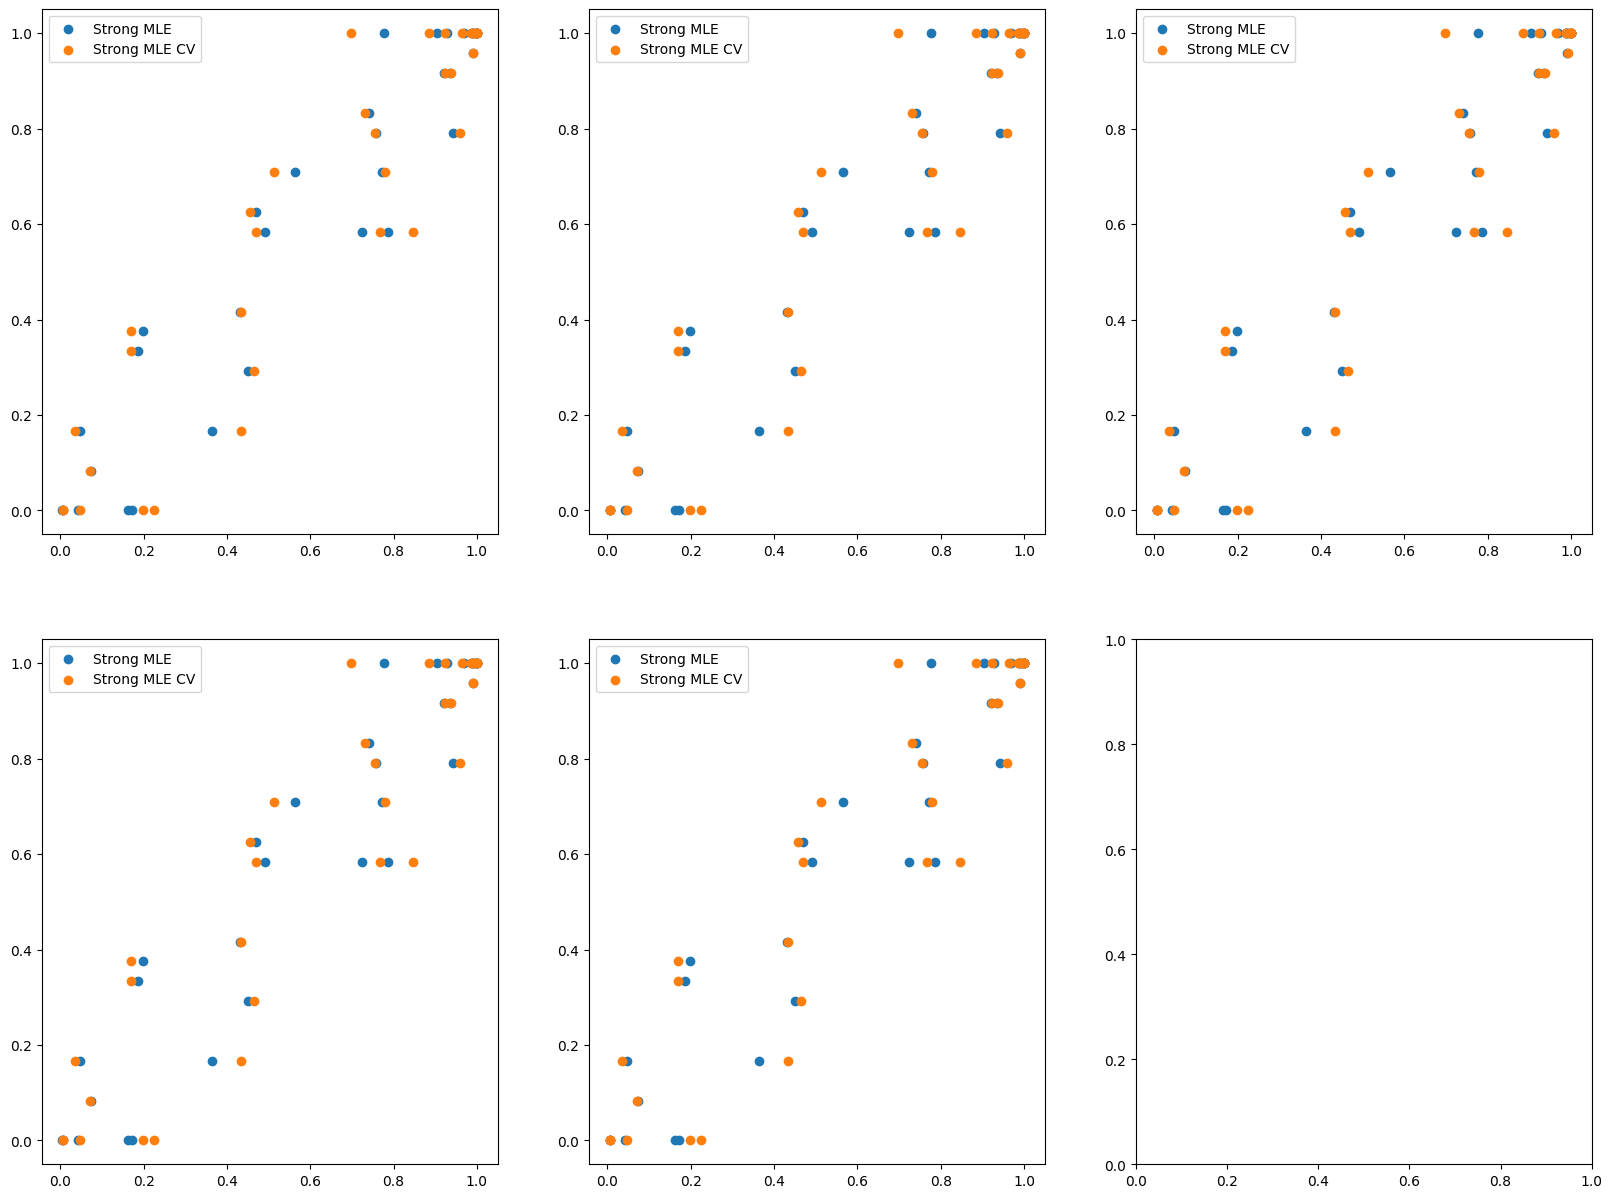

In [129]:
fig, axs = plt.subplots(2,3, figsize=(20, 15), facecolor='w', edgecolor='k')

axs = axs.ravel()

for i in range(5):

    axs[i].scatter(ps_2[0], (data[0]/24).reshape((35,1)))
    axs[i].scatter(p_mle_s[0], (data[0]/24).reshape((35,1)))
    #axs[i].title('Subject {}'.format(i))
    #axs[i].xlabel('Estimated probability')
    #axs[i].ylabel('Proportions')
    axs[i].legend(["Strong MLE", "Strong MLE CV"])

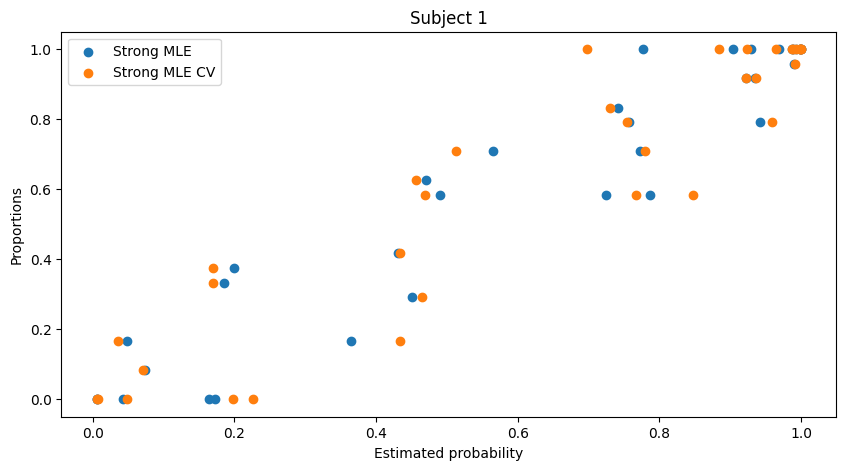

In [121]:
plt.figure(figsize=(10,5))   
plt.scatter(ps_2[0], (data[0]/24).reshape((35,1)))
plt.scatter(p_mle_s[0], (data[0]/24).reshape((35,1)))
plt.title('Subject 1')
plt.xlabel('Estimated probability')
plt.ylabel('Proportions')
plt.legend(["Strong MLE", "Strong MLE CV"])

Text(0, 0.5, 'Proportions')

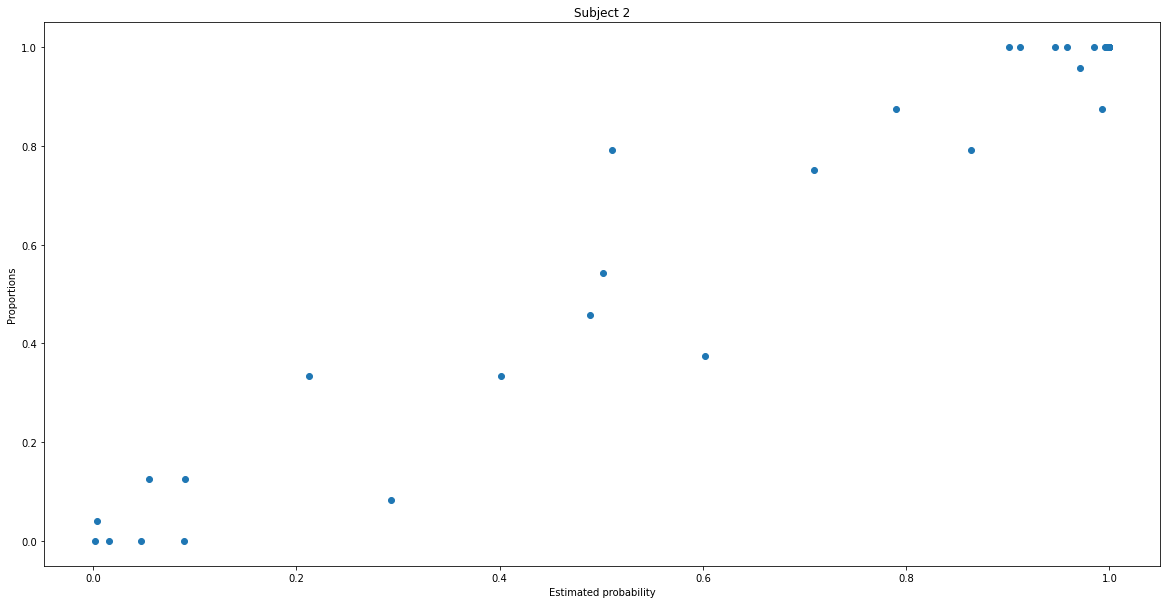

In [25]:
plt.figure()    
plt.scatter(ps_2[1], (data[1]/24).reshape((35,1)))
plt.title('Subject 2')
plt.xlabel('Estimated probability')
plt.ylabel('Proportions')

Text(0, 0.5, 'Proportions')

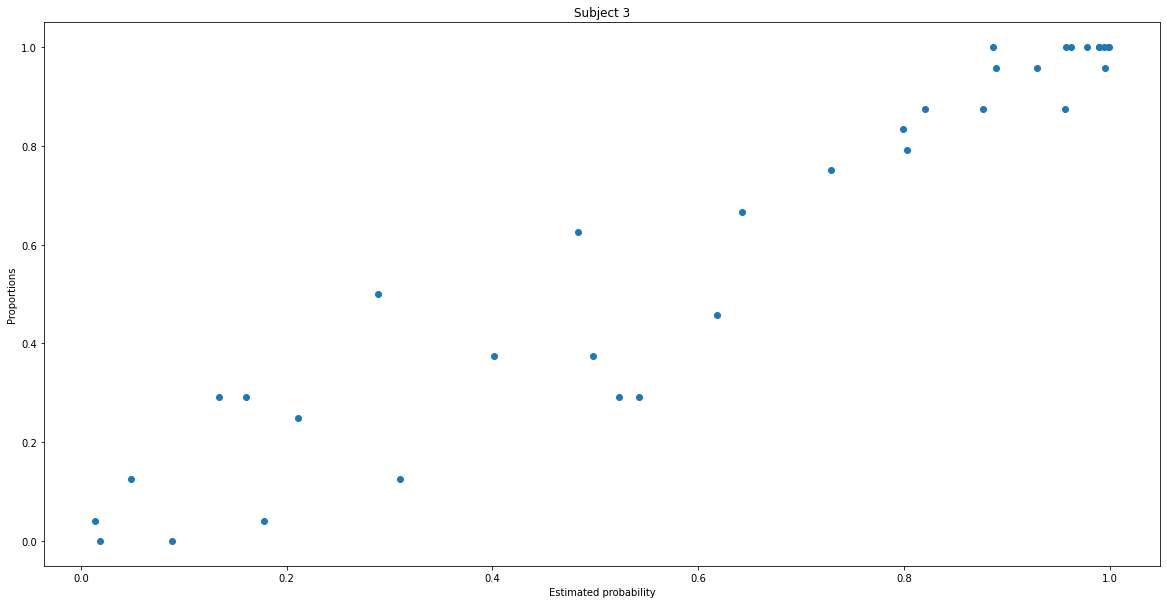

In [26]:
plt.figure()    
plt.scatter(ps_2[2], (data[2]/24).reshape((35,1)))
plt.title('Subject 3')
plt.xlabel('Estimated probability')
plt.ylabel('Proportions')

Text(0, 0.5, 'Proportions')

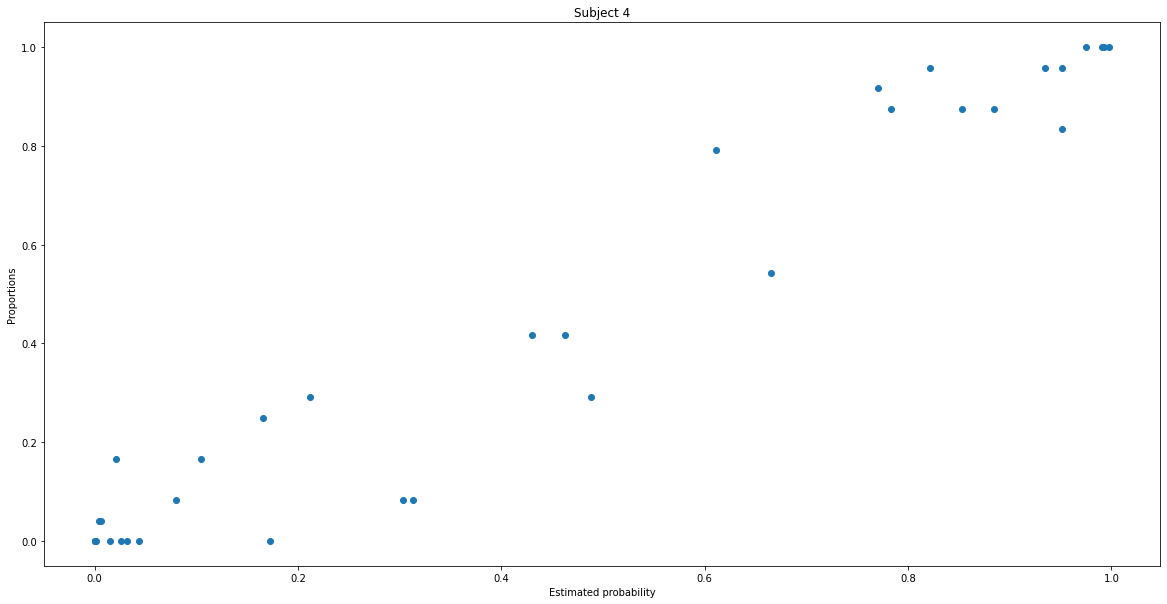

In [27]:
plt.figure()    
plt.scatter(ps_2[3], (data[3]/24).reshape((35,1)))
plt.title('Subject 4')
plt.xlabel('Estimated probability')
plt.ylabel('Proportions')

Text(0, 0.5, 'Proportions')

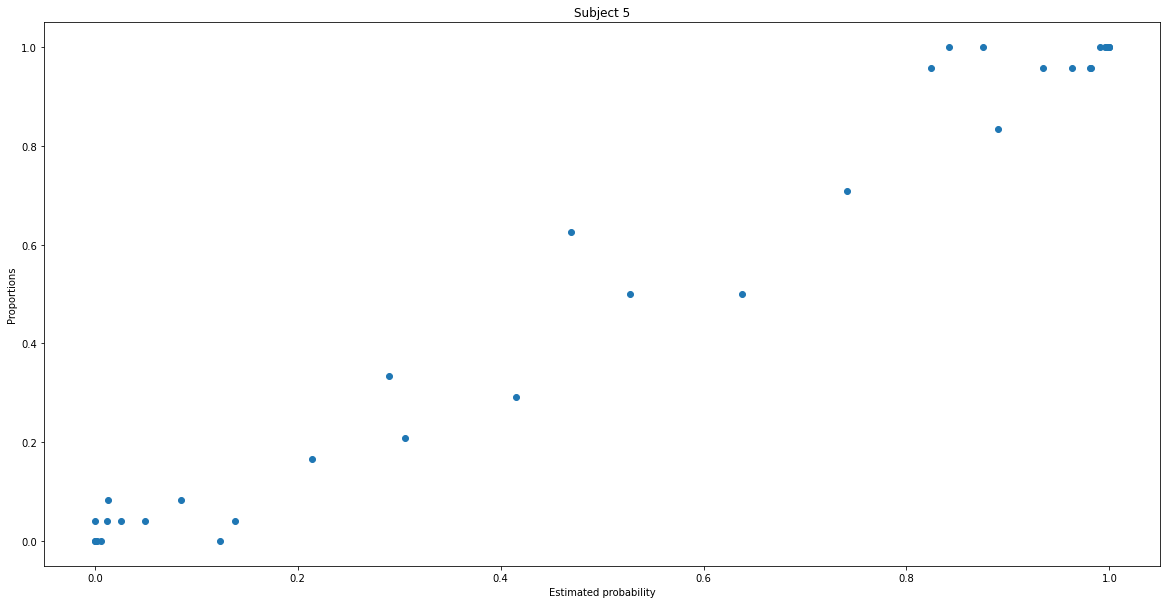

In [28]:
plt.figure()    
plt.scatter(ps_2[4], (data[4]/24).reshape((35,1)))
plt.title('Subject 5')
plt.xlabel('Estimated probability')
plt.ylabel('Proportions')